# PD 6
## Piotr Fic
### Import bibliotek

In [1]:
import numpy as np
from numpy import random
import math
import pandas as pd
import matplotlib.pyplot as plt

## Funkcje pomocnicze

### Aktywacja

In [3]:
def softmax(y):
    exp = np.exp(y-np.max(y))
    return exp/exp.sum(axis = 0, keepdims=True)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_der(x):
    return sigmoid(x)*(1-sigmoid(x))

def linear(x):
    return x

def linear_der(x):
    return 1

def tanh(x):
    exp = np.exp(x)
    exp_ = np.exp(-x)
    return (exp - exp_)/(exp + exp_)

def tanh_der(x):
    return (1-tanh(x)**2)

def ReLu(x):
    return np.maximum(0, x)

def ReLu_der(x):
    return np.where(x>0, 1, 0)

### Miary

In [4]:
def MSE(predicted, real):
    return np.mean((predicted - real)**2)

def MAE(predicted, real):
    return np.mean(np.abs(predicted - real))

def acc(x, y):
    return (x==y).mean()

### Wykresy i dane

In [97]:
def one_hot(y):
    y = y.astype(int)
    n_values = np.max(y) + 1
    return np.eye(n_values)[y.T][0]

def prepear_classif(df_train_p, df_test_p):
    df_train = pd.read_csv(df_train_p)
    df_test = pd.read_csv(df_test_p)
    #Separacja wektorów cech i odpowiedzi
    x_train, x_test = df_train.iloc[:, 0:2], df_test.iloc[:, 0:2]
    x_train, x_test = np.array(x_train), np.array(x_test)
    y_train, y_test = np.array(df_train.iloc[:, 2:3]), np.array(df_test.iloc[:, 2:3])
    #Normalizacja
    x_train, x_test = normalize(x_train), normalize(x_test)
    return x_train, one_hot(y_train), x_test, one_hot(y_test)

def prepear_data(df_train_p, df_test_p):
    df_train = pd.read_csv(df_train_p)
    df_test = pd.read_csv(df_test_p)
    #Separacja wektorów cech i odpowiedzi
    x_train, x_test = df_train.iloc[:, 1], df_test.iloc[:, 1]
    x_train, x_test = np.array(x_train), np.array(x_test)
    y_train, y_test = np.array(df_train.iloc[:, 2:3]), np.array(df_test.iloc[:, 2:3])
    #Normalizacja
    x_train, x_test = normalize(x_train), normalize(x_test)
    y_train, y_test = normalize(y_train), normalize(y_test)
    return x_train.reshape(-1, 1), y_train.reshape(-1, 1), x_test.reshape(-1, 1), y_test.reshape(-1, 1)

In [6]:
def predicted_real(predicted, real):
    plt.scatter(real, predicted, c='blue')
    p1 = max(max(predicted), max(real))
    p2 = min(min(predicted), min(real))
    plt.plot([p1, p2], [p1, p2], 'b-')
    plt.xlabel('True values')
    plt.ylabel('Predictions')
    plt.title('Predictions visualization on test set')
    plt.axis('equal')
    plt.show()

def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

## Implementacja MLP
 - dodanie uczenia z karą L2
 - implementacja uczenia ze zbiorem walidacyjnym

In [7]:
class Layer:
        
    def __init__(self, 
                 #Liczba neuronów w poprzedzającej i kolejnej warstwie
                 input_size: int, 
                 output_size: int,
                 #Domyślna funkcja aktywacyjna i jej pochodna                 
                 activation_fun = sigmoid, 
                 activation_fun_der = sigmoid_der,
                 ):
        
        #Wagi dla wszystkich neuronów - inicjalizacja Xavier
        self.biases = np.random.uniform(
            -math.sqrt(6)/ math.sqrt(input_size + output_size),
            math.sqrt(6)/ math.sqrt(input_size + output_size),
                    size=(output_size, 1)
                )
        
        self.weights = np.random.uniform(
            -math.sqrt(6)/ math.sqrt(input_size + output_size),
            math.sqrt(6)/ math.sqrt(input_size + output_size),
                    size=(output_size, input_size)
                )
            
        #Funkcja aktywacji i jej pochodna
        self.activation_fun = activation_fun
        self.activation_fun_der = activation_fun_der
    
    def predict(self, input):
        #Przekształca input z poprzedniej warstwy przez wagi i funkcję aktywacji 
        #Zwraca output do przekazania kolejnej warstwie
        return self.activation_fun(self.weights@input + self.biases)
    
    def forward(self, input):
        #Przekształca input z poprzedniej warstwy jedynie przez wagi
        return self.weights@input + self.biases

In [110]:
class Network:
    
    def __init__(self, layers: list, classif: bool):
        #classif
        self.classif = classif
        #Warstwy
        self.layers = layers
        self.momentum_w = [np.zeros(l.weights.shape) for l in layers]
        self.momentum_b = [np.zeros(l.biases.shape) for l in layers]
        self.g_w = [np.zeros(l.weights.shape) for l in layers]
        self.g_b = [np.zeros(l.biases.shape) for l in layers]
        
        if classif:
            self.layers[-1].activation_fun = softmax
        
    def predict(self, X):
        """Oblicza output na podstawie danych i parametrów warstw"""
        output = X.T
        for layer in self.layers:
            output = layer.predict(output)
        return output.T
    
    def forward(self, X):
        """Pełna metoda feedforward
        return: sumy, aktywacje"""
        sums = []
        activations = [X]
        activations_layer = X
        for layer in self.layers:
            sums_layer = layer.forward(activations_layer)
            sums.append(sums_layer)
            
            activations_layer = layer.activation_fun(sums_layer)
            activations.append(activations_layer)
            
        return sums, activations
    
    def L2_cost(self):
        """Funkcja pomocnicza, licząca części funkcji kosztu"""
        suma = 0
        for i in range(len(self.layers)):
            suma += np.sum(np.square(self.layers[i].weights))
        return suma
    
    def backprop(self, X, Y, l2):
        """Propagacja wsteczna błędu
        return: gradienty MSE"""
        #Batch size
        batch_size = Y.shape[1]
        
        #Wyliczenie feedforward obecnymi parametrami
        sums, activations = self.forward(X)
        
        #Macierze na poprawki parametrów
        delta_biases = []
        delta_weights = []
        
        n_layers = len(self.layers)
        err = [None]*n_layers
        
        #Wyliczenie err ostatniej warstwy
        if self.classif:
            err[-1] = Y - activations[-1]
        else:
            err[-1] = (Y - activations[-1])*self.layers[-1].activation_fun_der(sums[-1])
        
        #Regularyzacja L2
        err[-1] = err[-1] + l2*self.L2_cost()/(2*batch_size)
        
        #Propagacja wsteczna
        for i in reversed(range(len(err) -1)):
            act_f_der = self.layers[i].activation_fun_der(sums[i])
            err[i] = (self.layers[i+1].weights.transpose()@err[i+1]) * act_f_der 
                        
        delta_biases = [e@np.ones((batch_size, 1))/float(batch_size) 
                        for e in err]
        delta_weights = [np.dot(e, activations[i].transpose())/float(batch_size) + l2*self.layers[i].weights/batch_size
                        for i, e in enumerate(err)]
        
        return delta_biases, delta_weights
    
    def train(self, X, Y, 
              batch_size = 1, 
              etha = 0.001, 
              tol = 10**(-6), 
              n_iter = 500,
              #Regularyzacja L2
              l2 = 0,
              #Lambda dla momentum
              l_m = 0,
              #Beta dla RMSProp
              beta = 1,
              verbose = False):
        
        it = 0
        while it<n_iter:
            #Losowość przed podziałem zbioru, ziarno zapewnia identyczną permutację
            #w zmiennych objaśnających i zmiennej celu
            idx = random.permutation(X.shape[0])
            X_train = np.copy(X[idx])
            Y_train = np.copy(Y[idx])
            
            self.batch_gd(X_train, Y_train, batch_size, etha, l_m, beta, l2)
            
            #Wizualizacja procesu uczenia
            if(verbose):
                print("Epoche " + str(it) + " finished")
                for i in range(len(self.layers)):
                    print("Warstwa " + str(i) + " wagi:")
                    print(self.layers[i].weights)
                    print("Warstwa " + str(i) + " bias-y:")
                    print(self.layers[i].biases)
                print("\n")
            
            it += 1
            
        return it
    
    def train_valid(self, X, Y, 
              batch_size = 1, 
              etha = 0.001,
              #Uczenie ze zbiorem walidacyjnym
              score_fun = MSE,      
              tol = 10**(-6), 
              n_iter = 500,
              #Regularyzacja L2
              l2 = 0,
              #Lambda dla momentum
              l_m = 0,
              #Beta dla RMSProp
              beta = 1,
              verbose = False):
        """Trening sieci z kontrolą błędu na zbiorze walidacyjnym"""
        idx = random.permutation(X.shape[0])
        X = np.copy(X[idx])
        Y = np.copy(Y[idx])
            
        sp = int(0.8*len(X))
        X_val = X[sp:]
        Y_val = Y[sp:]
        X = X[:sp]
        Y = Y[:sp]
        
        it = 0
        old_score = 100
        new_score = 10
        while (old_score-new_score)>tol:
            old_score = new_score
            
            #Losowość przed podziałem zbioru, ziarno zapewnia identyczną permutację
            #w zmiennych objaśnających i zmiennej celu
            idx = random.permutation(X.shape[0])
            X_train = np.copy(X[idx])
            Y_train = np.copy(Y[idx])
            
            self.batch_gd(X_train, Y_train, batch_size, etha, l_m, beta, l2)
            
            pred = self.predict(X_val)
            new_score = score_fun(pred, Y_val)
            print(old_score-new_score)
            
            #Wizualizacja procesu uczenia
            if(verbose):
                print("Epoche " + str(it) + " finished")
                for i in range(len(self.layers)):
                    print("Warstwa " + str(i) + " wagi:")
                    print(self.layers[i].weights)
                    print("Warstwa " + str(i) + " bias-y:")
                    print(self.layers[i].biases)
                print("\n")
            
            it += 1
        
        return it
    
    def gd(self, X, Y, etha, l_m, beta, l2):
        """Trening sieci podstawową metodą Gradient Descent"""
        b, w = self.backprop(X, Y, l2)
        for i in range(len(self.layers)):
            #Aktualizacja momentum
            self.momentum_w[i] = w[i]+l_m*self.momentum_w[i]
            self.momentum_b[i] = b[i]+l_m*self.momentum_b[i]
            
            #Aktualizacja RMSProp
            self.g_w[i] = (1-beta)*w[i]*w[i]+beta*self.g_w[i]
            self.g_b[i] = (1-beta)*b[i]*b[i]+beta*self.g_b[i]
        
            l = self.layers[i]
            if(beta):
                l.biases = l.biases + etha*self.momentum_b[i] + (etha*b[i])/np.sqrt(0.00001+self.g_b[i]) 
                l.weights = l.weights + etha*self.momentum_w[i] + (etha*w[i])/np.sqrt(0.00001+self.g_w[i])
            else:
                l.biases = l.biases + etha*self.momentum_b[i]
                l.weights = l.weights + etha*self.momentum_w[i]
            
        return
    
    def batch_gd(self, X, Y, batch_size, etha, l_m, beta, l2):
        """Trening sieci metodą Mini-batch Gradient Descent"""
        #Metoda train uprzednio dokonuje permutacji zbioru
        #Wywołanie metody gradient descent na kolejnych batch-ach
        i=0
        while(i<len(Y)):
            x = X[i:i+batch_size]
            y = Y[i:i+batch_size]
            i += batch_size
            self.gd(x.T, y.T, etha, l_m, beta, l2)
        return
        

# Test działania

In [23]:
def exp_plot(sig, lin, tanh, relu, ep):
    plt.plot(range(ep), sig, label = "sigmoid")
    plt.plot(range(ep), lin, label = "linear")
    plt.plot(range(ep), tanh, label = "tanh")
    plt.plot(range(ep), relu, label = "ReLu")
    plt.legend()
    plt.title("MSE during training on training set.")
    plt.xlabel("epoch")
    plt.ylabel("MSE")
    plt.show()
    
def exp_plot_c(sig, lin, tanh, relu, ep):
    plt.plot(range(ep), sig, label = "sigmoid")
    plt.plot(range(ep), lin, label = "linear")
    plt.plot(range(ep), tanh, label = "tanh")
    plt.plot(range(ep), relu, label = "ReLu")
    plt.legend()
    plt.title("ACC during training on training set.")
    plt.xlabel("epoch")
    plt.ylabel("ACC")
    plt.show()

### architektury

In [14]:
n = arch_2(sigmoid, sigmoid_der, classif=False)

In [17]:
n.layers[1].weights

array([[-0.75992707,  0.20872521, -0.77158849,  0.0395512 ,  0.73384217],
       [ 0.64113817,  0.05781228,  0.0776291 , -0.5649736 , -0.49115549],
       [-0.55901076,  0.62850113,  0.44893108,  0.35063477,  0.33951072],
       [-0.21077905, -0.22143794,  0.49372311,  0.67613177, -0.08279481],
       [ 0.65040706, -0.20308315, -0.7411157 ,  0.28941584,  0.12259283]])

In [19]:
n.L2_cost()

9.301990771154415

In [37]:
x_train[1:10]

array([[0.72374147],
       [0.40655118],
       [0.0225551 ],
       [0.39740568],
       [0.17724254],
       [0.25328814],
       [0.91368186],
       [0.37466166],
       [0.29952627]])

In [49]:
y_train[4:]

array([[0.33333333],
       [0.        ],
       [0.        ],
       ...,
       [0.66666667],
       [0.66666667],
       [0.66666667]])

In [45]:
id = int(0.333333333*len(x_train))

In [9]:
#1-5-1
def arch_1(f, f_d, classif, inp=1, outp=1):
    l1 = Layer(inp, 5, activation_fun=f, activation_fun_der=f_d)
    l2 = Layer(5, outp, activation_fun=linear, activation_fun_der=linear_der)
    return Network([l1, l2], classif)

In [13]:
#1-5-5-1
def arch_2(f, f_d, classif, inp=1, outp=1):
    l1 = Layer(inp, 5, activation_fun=f, activation_fun_der=f_d)
    l2 = Layer(5, 5, activation_fun=f, activation_fun_der=f_d)
    l3 = Layer(5, outp, activation_fun=linear, activation_fun_der=linear_der)
    return Network([l1, l2, l3], classif)

In [117]:
#1-5-5-5-1
def arch_3(f, f_d, classif, inp=1, outp=1):
    l1 = Layer(inp, 5, activation_fun=f, activation_fun_der=f_d)
    l2 = Layer(5, 5, activation_fun=f, activation_fun_der=f_d)
    l3 = Layer(5, 5, activation_fun=f, activation_fun_der=f_d)
    l4 = Layer(5, outp, activation_fun=linear, activation_fun_der=linear_der)
    return Network([l1, l2, l3, l4], classif)

## Regresja
### df: steps-large

In [98]:
x_train, y_train, x_test, y_test = prepear_data("./mio1/regression/steps-large-training.csv",
                                               "./mio1/regression/steps-large-test.csv")

### architektura: 1-5-1

In [95]:
n_sig = arch_1(sigmoid, sigmoid_der, False)
n_lin = arch_1(linear, linear_der, False)
n_tanh = arch_1(tanh, tanh_der, False)
n_relu = arch_1(ReLu, ReLu_der, False)

ep = 50
sig = [0]*ep
lin = [0]*ep
tan = [0]*ep
relu = [0]*ep

for i in range(ep):
    #sigmoid
    n_sig.train(x_train, y_train, batch_size=500, n_iter=1, beta=0.9, l_m=0.9, etha = 0.01)
    res = n_sig.predict(x_train)
    sig[i] = MSE(y_train, res)
    #linear
    n_lin.train(x_train, y_train, batch_size=500, n_iter=1, beta=0.9, l_m=0.9, etha = 0.001)
    res = n_lin.predict(x_train)
    lin[i] = MSE(y_train, res)
    #tanh
    n_tanh.train(x_train, y_train, batch_size=500, n_iter=1, beta=0.9, l_m=0.9, etha = 0.001)
    res = n_tanh.predict(x_train)
    tan[i] = MSE(y_train, res)
    #ReLu
    n_relu.train(x_train, y_train, batch_size=500, n_iter=1, beta=0.9, l_m=0.9, etha = 0.001)
    res = n_relu.predict(x_train)
    relu[i] = MSE(y_train, res)

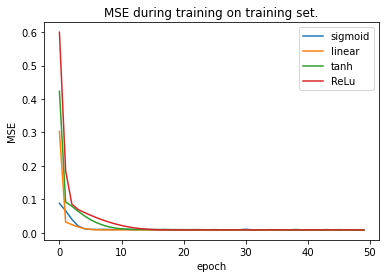

In [96]:
exp_plot(sig, lin, tan, relu, ep)

### architektura: 1-5-5-1

In [32]:
# n_sig = arch_2(sigmoid, sigmoid_der, False)
# n_lin = arch_2(linear, linear_der, False)
n_tanh = arch_2(tanh, tanh_der, False)
# n_relu = arch_2(ReLu, ReLu_der, False)

ep = 50
sig = [0]*ep
lin = [0]*ep
tan = [0]*ep
relu = [0]*ep

for i in range(ep):
    #sigmoid
#     n_sig.train(x_train, y_train, batch_size=500, n_iter=1, beta=0.9, l_m=0.9, etha = 0.01)
#     res = n_sig.predict(x_train)
#     sig[i] = MSE(y_train, res)
    #linear
#     n_lin.train(x_train, y_train, batch_size=500, n_iter=1, beta=0.9, l_m=0.9, etha = 0.001)
#     res = n_lin.predict(x_train)
#     lin[i] = MSE(y_train, res)
    #tanh
    n_tanh.train(x_train, y_train, batch_size=500, n_iter=1, beta=0.9, l_m=0.9, etha = 0.001, l2=0.7)
    res = n_tanh.predict(x_train)
    tan[i] = MSE(y_train, res)
    #ReLu
#     n_relu.train(x_train, y_train, batch_size=500, n_iter=1, beta=0.9, l_m=0.9, etha = 0.001)
#     res = n_relu.predict(x_train)
#     relu[i] = MSE(y_train, res)

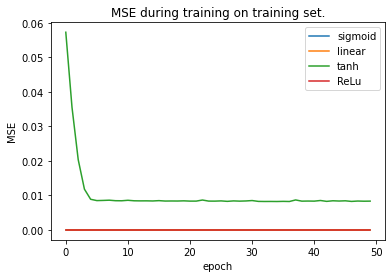

In [33]:
exp_plot(sig, lin, tan, relu, ep)

In [60]:
x_train[8000:]

array([[0.99379773],
       [0.5276205 ],
       [0.24750275],
       ...,
       [0.6601851 ],
       [0.61256418],
       [0.63671731]])

In [111]:
n = arch_2(tanh, tanh_der, False)
n.train_valid(x_train, y_train, batch_size=8000, etha = 0.001, tol=10**(-6))

9.915869030177955
0.002877340965420222
0.0027497524418190894
0.0027463780878874133
0.0027433239246448804
0.002736865570181976
0.0027262403963683735
0.002710823222067435
0.00269007312443955
0.0026635406095845623
0.00263087495993667
0.00259183056998602
0.002546271891687525
0.0024941766370539936
0.0024356369218125687
0.002370858087353128
0.0023001550108531638
0.0022239458057840417
0.002142742924769854
0.002057141798959515
0.001967807275120838
0.0018754582341257153
0.001780850882122393
0.001684761288682727
0.0015879677965024257
0.0014912339395674358
0.0013952924793622402
0.0013008311037459516
0.0012084802361416874
0.0011188032820597209
0.0010322895058703686
0.0009493495939053923
0.0008703138305590913
0.0007954327006756863
0.0007248796404705667
0.0006587555942517663
0.0005970949963717536
0.0005398727859017034
0.0004870120723879795
0.000438392100379454
0.00039385620323063864
0.00035321948793701555
0.00031627604776132516
0.00028280555416587867
0.0002525791309352689
0.00022536445913198117
0.00

348

In [114]:
n = arch_2(tanh, tanh_der, False)
n.train(x_train, y_train, batch_size=8000, etha = 0.001, n_iter=500)

500

In [115]:
pred = n.predict(x_test)

In [113]:
MSE(predicted=pred, real=y_test)

0.0086382663265674

In [116]:
MSE(predicted=pred, real=y_test)

0.008669352495735808

### architektura: 1-5-5-5-1

In [99]:
n_sig = arch_3(sigmoid, sigmoid_der, False)
n_lin = arch_3(linear, linear_der, False)
n_tanh = arch_3(tanh, tanh_der, False)
n_relu = arch_3(ReLu, ReLu_der, False)

ep = 50
sig = [0]*ep
lin = [0]*ep
tan = [0]*ep
relu = [0]*ep

for i in range(ep):
    #sigmoid
    n_sig.train(x_train, y_train, batch_size=500, n_iter=1, beta=0.9, l_m=0.9, etha = 0.01)
    res = n_sig.predict(x_train)
    sig[i] = MSE(y_train, res)
    #linear
    n_lin.train(x_train, y_train, batch_size=500, n_iter=1, beta=0.9, l_m=0.9, etha = 0.001)
    res = n_lin.predict(x_train)
    lin[i] = MSE(y_train, res)
    #tanh
    n_tanh.train(x_train, y_train, batch_size=500, n_iter=1, beta=0.9, l_m=0.9, etha = 0.001)
    res = n_tanh.predict(x_train)
    tan[i] = MSE(y_train, res)
    #ReLu
    n_relu.train(x_train, y_train, batch_size=500, n_iter=1, beta=0.9, l_m=0.9, etha = 0.001)
    res = n_relu.predict(x_train)
    relu[i] = MSE(y_train, res)

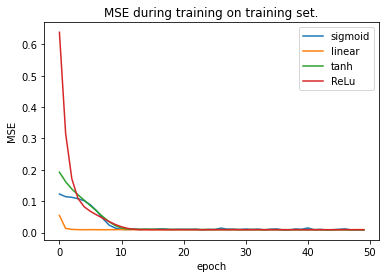

In [100]:
exp_plot(sig, lin, tan, relu, ep)

### df: multimodal-large

In [101]:
x_train, y_train, x_test, y_test = prepear_data("./mio1/regression/multimodal-large-training.csv",
                                               "./mio1/regression/multimodal-large-test.csv")

### architektura: 1-5-1

In [104]:
n_sig = arch_1(sigmoid, sigmoid_der, False)
n_lin = arch_1(linear, linear_der, False)
n_tanh = arch_1(tanh, tanh_der, False)
n_relu = arch_1(ReLu, ReLu_der, False)

ep = 50
sig = [0]*ep
lin = [0]*ep
tan = [0]*ep
relu = [0]*ep

for i in range(ep):
    #sigmoid
    n_sig.train(x_train, y_train, batch_size=500, n_iter=1, beta=0.9, l_m=0.9, etha = 0.01)
    res = n_sig.predict(x_train)
    sig[i] = MSE(y_train, res)
    #linear
    n_lin.train(x_train, y_train, batch_size=500, n_iter=1, beta=0.9, l_m=0.9, etha = 0.001)
    res = n_lin.predict(x_train)
    lin[i] = MSE(y_train, res)
    #tanh
    n_tanh.train(x_train, y_train, batch_size=500, n_iter=1, beta=0.9, l_m=0.9, etha = 0.001)
    res = n_tanh.predict(x_train)
    tan[i] = MSE(y_train, res)
    #ReLu
    n_relu.train(x_train, y_train, batch_size=500, n_iter=1, beta=0.9, l_m=0.9, etha = 0.001)
    res = n_relu.predict(x_train)
    relu[i] = MSE(y_train, res)

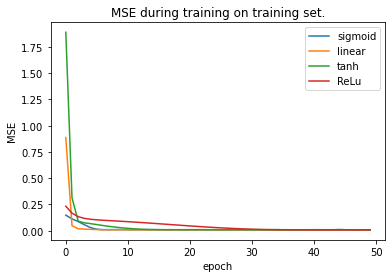

In [105]:
exp_plot(sig, lin, tan, relu, ep)

### architektura: 1-5-5-1

In [108]:
n_sig = arch_2(sigmoid, sigmoid_der, False)
n_lin = arch_2(linear, linear_der, False)
n_tanh = arch_2(tanh, tanh_der, False)
n_relu = arch_2(ReLu, ReLu_der, False)

ep = 50
sig = [0]*ep
lin = [0]*ep
tan = [0]*ep
relu = [0]*ep

for i in range(ep):
    #sigmoid
    n_sig.train(x_train, y_train, batch_size=500, n_iter=1, beta=0.9, l_m=0.9, etha = 0.01)
    res = n_sig.predict(x_train)
    sig[i] = MSE(y_train, res)
    #linear
    n_lin.train(x_train, y_train, batch_size=500, n_iter=1, beta=0.9, l_m=0.9, etha = 0.001)
    res = n_lin.predict(x_train)
    lin[i] = MSE(y_train, res)
    #tanh
    n_tanh.train(x_train, y_train, batch_size=500, n_iter=1, beta=0.9, l_m=0.9, etha = 0.001)
    res = n_tanh.predict(x_train)
    tan[i] = MSE(y_train, res)
    #ReLu
    n_relu.train(x_train, y_train, batch_size=500, n_iter=1, beta=0.9, l_m=0.9, etha = 0.001)
    res = n_relu.predict(x_train)
    relu[i] = MSE(y_train, res)

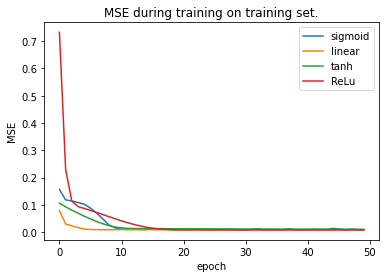

In [109]:
exp_plot(sig, lin, tan, relu, ep)

### architektura: 1-5-5-5-1

In [110]:
n_sig = arch_3(sigmoid, sigmoid_der, False)
n_lin = arch_3(linear, linear_der, False)
n_tanh = arch_3(tanh, tanh_der, False)
n_relu = arch_3(ReLu, ReLu_der, False)

ep = 50
sig = [0]*ep
lin = [0]*ep
tan = [0]*ep
relu = [0]*ep

for i in range(ep):
    #sigmoid
    n_sig.train(x_train, y_train, batch_size=500, n_iter=1, beta=0.9, l_m=0.9, etha = 0.01)
    res = n_sig.predict(x_train)
    sig[i] = MSE(y_train, res)
    #linear
    n_lin.train(x_train, y_train, batch_size=500, n_iter=1, beta=0.9, l_m=0.9, etha = 0.001)
    res = n_lin.predict(x_train)
    lin[i] = MSE(y_train, res)
    #tanh
    n_tanh.train(x_train, y_train, batch_size=500, n_iter=1, beta=0.9, l_m=0.9, etha = 0.001)
    res = n_tanh.predict(x_train)
    tan[i] = MSE(y_train, res)
    #ReLu
    n_relu.train(x_train, y_train, batch_size=500, n_iter=1, beta=0.9, l_m=0.9, etha = 0.001)
    res = n_relu.predict(x_train)
    relu[i] = MSE(y_train, res)

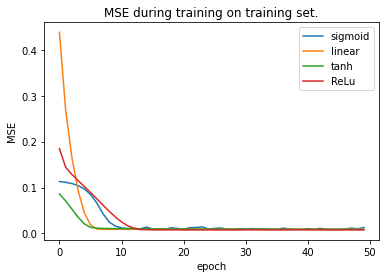

In [111]:
exp_plot(sig, lin, tan, relu, ep)

## klasyfikacja
### df: rings5-regular

In [113]:
x_train, y_train, x_test, y_test = prepear_classif("./mio1/classification/rings5-regular-training.csv",
                                               "./mio1/classification/rings5-regular-test.csv")
train_true = np.argmax(y_train, axis=1)
test_true = np.argmax(y_test, axis=1)

### architektura: 1-5-1

In [135]:
n_sig = arch_1(sigmoid, sigmoid_der, True, 2, 5)
n_lin = arch_1(linear, linear_der, True, 2, 5)
n_tanh = arch_1(tanh, tanh_der, True, 2, 5)
n_relu = arch_1(ReLu, ReLu_der, True, 2, 5)

ep = 500
sig = [0]*ep
lin = [0]*ep
tan = [0]*ep
relu = [0]*ep

for i in range(ep):
    #sigmoid
    n_sig.train(x_train, y_train, batch_size=1000, n_iter=1, beta=0.7, l_m=0.99, etha = 0.01)
    res = n_sig.predict(x_train)
    pred = np.argmax(res, axis=1)
    sig[i] = acc(train_true, pred)
    #linear
    n_lin.train(x_train, y_train, batch_size=1000, n_iter=1, beta=0.7, l_m=0.99, etha = 0.01)
    res = n_lin.predict(x_train)
    pred = np.argmax(res, axis=1)
    lin[i] = acc(train_true, pred)
    #tanh
    n_tanh.train(x_train, y_train, batch_size=1000, n_iter=1, beta=0.7, l_m=0.99, etha = 0.01)
    res = n_tanh.predict(x_train)
    pred = np.argmax(res, axis=1)
    tan[i] = acc(train_true, pred)
    #ReLu
    n_relu.train(x_train, y_train, batch_size=1000, n_iter=1, beta=0.7, l_m=0.99, etha = 0.01)
    res = n_relu.predict(x_train)
    pred = np.argmax(res, axis=1)
    relu[i] = acc(train_true, pred)

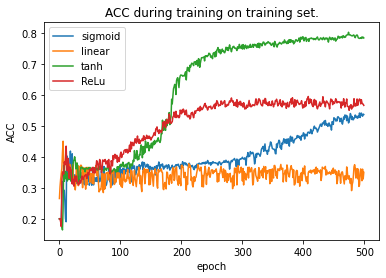

In [136]:
exp_plot_c(sig, lin, tan, relu, ep)

### architektura: 1-5-5-1

In [137]:
n_sig = arch_2(sigmoid, sigmoid_der, True, 2, 5)
n_lin = arch_2(linear, linear_der, True, 2, 5)
n_tanh = arch_2(tanh, tanh_der, True, 2, 5)
n_relu = arch_2(ReLu, ReLu_der, True, 2, 5)

ep = 500
sig = [0]*ep
lin = [0]*ep
tan = [0]*ep
relu = [0]*ep

for i in range(ep):
    #sigmoid
    n_sig.train(x_train, y_train, batch_size=1000, n_iter=1, beta=0.7, l_m=0.99, etha = 0.01)
    res = n_sig.predict(x_train)
    pred = np.argmax(res, axis=1)
    sig[i] = acc(train_true, pred)
    #linear
    n_lin.train(x_train, y_train, batch_size=1000, n_iter=1, beta=0.7, l_m=0.99, etha = 0.01)
    res = n_lin.predict(x_train)
    pred = np.argmax(res, axis=1)
    lin[i] = acc(train_true, pred)
    #tanh
    n_tanh.train(x_train, y_train, batch_size=1000, n_iter=1, beta=0.7, l_m=0.99, etha = 0.01)
    res = n_tanh.predict(x_train)
    pred = np.argmax(res, axis=1)
    tan[i] = acc(train_true, pred)
    #ReLu
    n_relu.train(x_train, y_train, batch_size=1000, n_iter=1, beta=0.7, l_m=0.99, etha = 0.01)
    res = n_relu.predict(x_train)
    pred = np.argmax(res, axis=1)
    relu[i] = acc(train_true, pred)

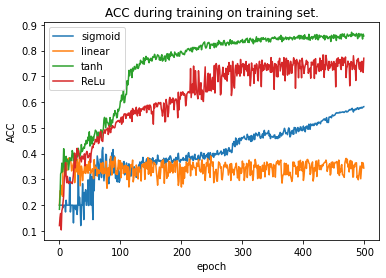

In [138]:
exp_plot_c(sig, lin, tan, relu, ep)

### architektura: 1-5-5-5-1

In [139]:
n_sig = arch_3(sigmoid, sigmoid_der, True, 2, 5)
n_lin = arch_3(linear, linear_der, True, 2, 5)
n_tanh = arch_3(tanh, tanh_der, True, 2, 5)
n_relu = arch_3(ReLu, ReLu_der, True, 2, 5)

ep = 500
sig = [0]*ep
lin = [0]*ep
tan = [0]*ep
relu = [0]*ep

for i in range(ep):
    #sigmoid
    n_sig.train(x_train, y_train, batch_size=1000, n_iter=1, beta=0.7, l_m=0.99, etha = 0.01)
    res = n_sig.predict(x_train)
    pred = np.argmax(res, axis=1)
    sig[i] = acc(train_true, pred)
    #linear
    n_lin.train(x_train, y_train, batch_size=1000, n_iter=1, beta=0.7, l_m=0.99, etha = 0.01)
    res = n_lin.predict(x_train)
    pred = np.argmax(res, axis=1)
    lin[i] = acc(train_true, pred)
    #tanh
    n_tanh.train(x_train, y_train, batch_size=1000, n_iter=1, beta=0.7, l_m=0.99, etha = 0.01)
    res = n_tanh.predict(x_train)
    pred = np.argmax(res, axis=1)
    tan[i] = acc(train_true, pred)
    #ReLu
    n_relu.train(x_train, y_train, batch_size=1000, n_iter=1, beta=0.7, l_m=0.99, etha = 0.01)
    res = n_relu.predict(x_train)
    pred = np.argmax(res, axis=1)
    relu[i] = acc(train_true, pred)

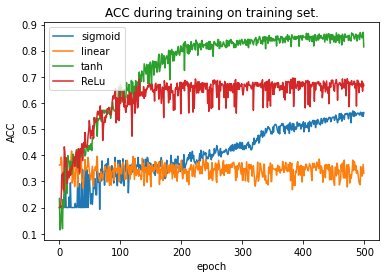

In [140]:
exp_plot_c(sig, lin, tan, relu, ep)

### df: rings3-regular

In [141]:
x_train, y_train, x_test, y_test = prepear_classif("./mio1/classification/rings3-regular-training.csv",
                                               "./mio1/classification/rings3-regular-test.csv")
train_true = np.argmax(y_train, axis=1)
test_true = np.argmax(y_test, axis=1)

### architektura: 1-5-1

In [146]:
n_sig = arch_1(sigmoid, sigmoid_der, True, 2, 3)
n_lin = arch_1(linear, linear_der, True, 2, 3)
n_tanh = arch_1(tanh, tanh_der, True, 2, 3)
n_relu = arch_1(ReLu, ReLu_der, True, 2, 3)

ep = 500
sig = [0]*ep
lin = [0]*ep
tan = [0]*ep
relu = [0]*ep

for i in range(ep):
    #sigmoid
    n_sig.train(x_train, y_train, batch_size=1000, n_iter=1, beta=0.7, l_m=0.9, etha = 0.1)
    res = n_sig.predict(x_train)
    pred = np.argmax(res, axis=1)
    sig[i] = acc(train_true, pred)
    #linear
    n_lin.train(x_train, y_train, batch_size=1000, n_iter=1, beta=0.7, l_m=0.9, etha = 0.1)
    res = n_lin.predict(x_train)
    pred = np.argmax(res, axis=1)
    lin[i] = acc(train_true, pred)
    #tanh
    n_tanh.train(x_train, y_train, batch_size=1000, n_iter=1, beta=0.7, l_m=0.9, etha = 0.1)
    res = n_tanh.predict(x_train)
    pred = np.argmax(res, axis=1)
    tan[i] = acc(train_true, pred)
    #ReLu
    n_relu.train(x_train, y_train, batch_size=1000, n_iter=1, beta=0.7, l_m=0.9, etha = 0.1)
    res = n_relu.predict(x_train)
    pred = np.argmax(res, axis=1)
    relu[i] = acc(train_true, pred)

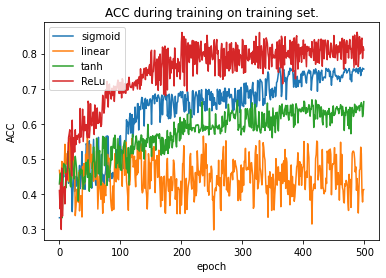

In [147]:
exp_plot_c(sig, lin, tan, relu, ep)

### architektura: 1-5-5-1

In [150]:
n_sig = arch_2(sigmoid, sigmoid_der, True, 2, 3)
n_lin = arch_2(linear, linear_der, True, 2, 3)
n_tanh = arch_2(tanh, tanh_der, True, 2, 3)
n_relu = arch_2(ReLu, ReLu_der, True, 2, 3)

ep = 500
sig = [0]*ep
lin = [0]*ep
tan = [0]*ep
relu = [0]*ep

for i in range(ep):
    #sigmoid
    n_sig.train(x_train, y_train, batch_size=1000, n_iter=1, beta=0.7, l_m=0.9, etha = 0.01)
    res = n_sig.predict(x_train)
    pred = np.argmax(res, axis=1)
    sig[i] = acc(train_true, pred)
    #linear
    n_lin.train(x_train, y_train, batch_size=1000, n_iter=1, beta=0.7, l_m=0.9, etha = 0.01)
    res = n_lin.predict(x_train)
    pred = np.argmax(res, axis=1)
    lin[i] = acc(train_true, pred)
    #tanh
    n_tanh.train(x_train, y_train, batch_size=1000, n_iter=1, beta=0.7, l_m=0.9, etha = 0.01)
    res = n_tanh.predict(x_train)
    pred = np.argmax(res, axis=1)
    tan[i] = acc(train_true, pred)
    #ReLu
    n_relu.train(x_train, y_train, batch_size=1000, n_iter=1, beta=0.7, l_m=0.9, etha = 0.01)
    res = n_relu.predict(x_train)
    pred = np.argmax(res, axis=1)
    relu[i] = acc(train_true, pred)

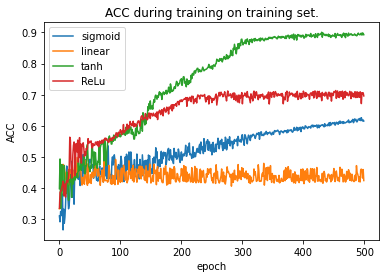

In [151]:
exp_plot_c(sig, lin, tan, relu, ep)

### architektura: 1-5-5-5-1

In [152]:
n_sig = arch_3(sigmoid, sigmoid_der, True, 2, 3)
n_lin = arch_3(linear, linear_der, True, 2, 3)
n_tanh = arch_3(tanh, tanh_der, True, 2, 3)
n_relu = arch_3(ReLu, ReLu_der, True, 2, 3)

ep = 500
sig = [0]*ep
lin = [0]*ep
tan = [0]*ep
relu = [0]*ep

for i in range(ep):
    #sigmoid
    n_sig.train(x_train, y_train, batch_size=1000, n_iter=1, beta=0.7, l_m=0.9, etha = 0.01)
    res = n_sig.predict(x_train)
    pred = np.argmax(res, axis=1)
    sig[i] = acc(train_true, pred)
    #linear
    n_lin.train(x_train, y_train, batch_size=1000, n_iter=1, beta=0.7, l_m=0.9, etha = 0.01)
    res = n_lin.predict(x_train)
    pred = np.argmax(res, axis=1)
    lin[i] = acc(train_true, pred)
    #tanh
    n_tanh.train(x_train, y_train, batch_size=1000, n_iter=1, beta=0.7, l_m=0.9, etha = 0.01)
    res = n_tanh.predict(x_train)
    pred = np.argmax(res, axis=1)
    tan[i] = acc(train_true, pred)
    #ReLu
    n_relu.train(x_train, y_train, batch_size=1000, n_iter=1, beta=0.7, l_m=0.9, etha = 0.01)
    res = n_relu.predict(x_train)
    pred = np.argmax(res, axis=1)
    relu[i] = acc(train_true, pred)

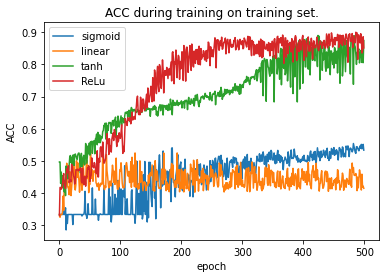

In [153]:
exp_plot_c(sig, lin, tan, relu, ep)

## Wnioski
- szczególnie w zadaniu klasyfikacji wybór funkcji aktywacji ma duże znaczenie
- możemy zaobserwować, że funkcje tanh i ReLu przekładają się na szybszą i stabilniejszą zbieżność względem sigmoidu i funkcji liniowej